# Recommender Systems



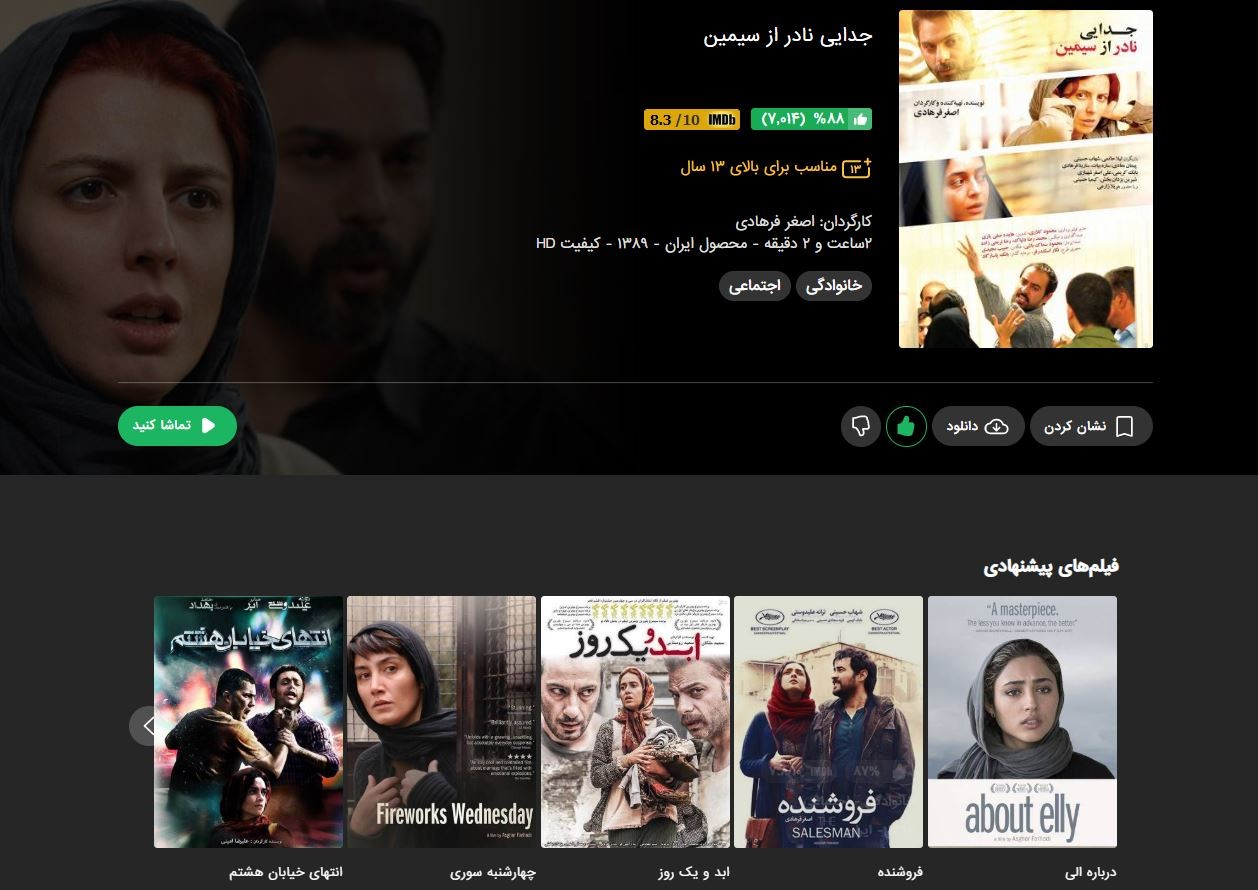

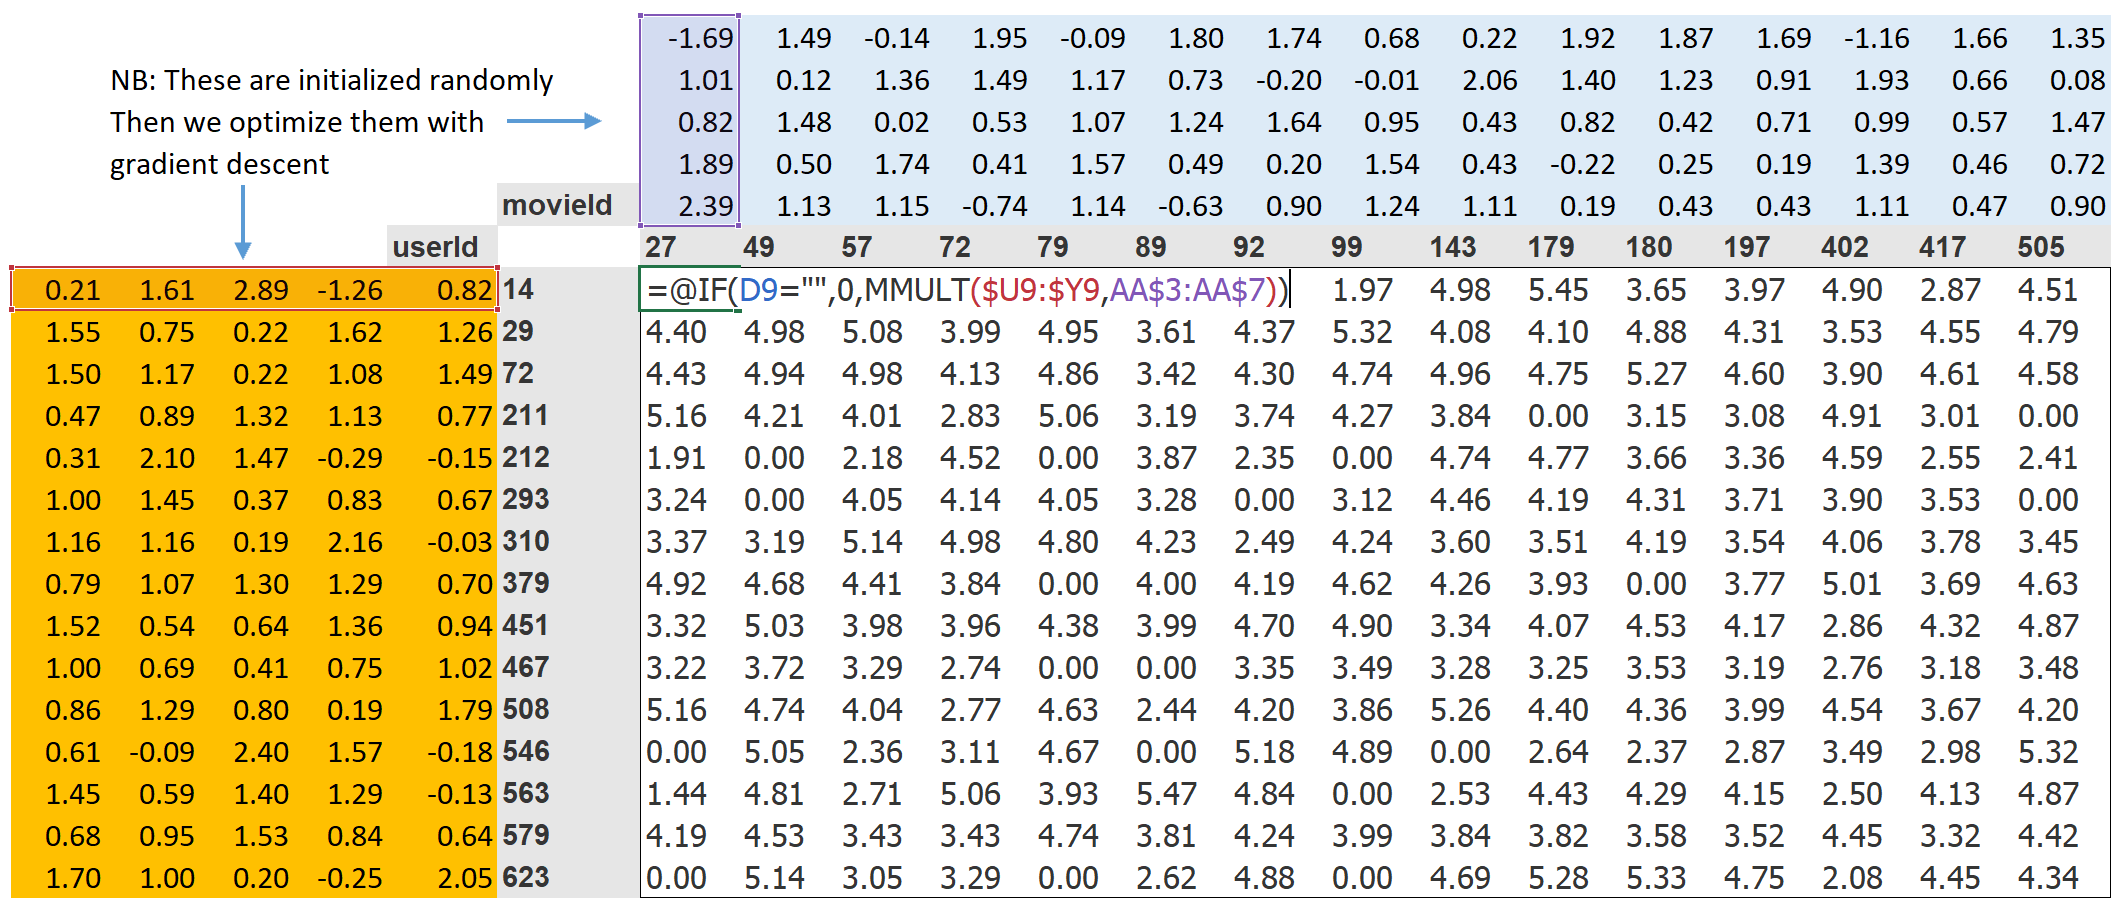

Source: https://raw.githubusercontent.com/fastai/fastbook/master/images/att_00041.png

In [ ]:
# Install libraries

%%capture

! pip install -Uqq fastai

In [ ]:
# Download the dataset

%%capture

! rm -rf *
! wget http://156.253.5.172/data.zip
! unzip data.zip
! rm data.zip

In [ ]:
# Import libraries

%%capture

# General libraries

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib
import numpy as np
from pathlib import Path
import pickle
import gc
import datetime
from dateutil.relativedelta import relativedelta
import gc
from scipy.sparse import csr_matrix

import pandas as pd

# FastAI
from fastai.collab import *
from fastai.tabular.all import *

In [ ]:
# Set variables

data_dir = Path("data")
train_file = data_dir/"train.csv"
test_file = data_dir/"test.csv"

In [ ]:
# Read the training set

train_df = pd.read_csv(train_file, dtype={"userId":"str", "itemId": "str", "rating": "int8"} , parse_dates=["date"])
test_df = pd.read_csv(test_file, dtype={"userId":"str", "itemId": "str"} , parse_dates=["date"])

min_date = train_df.date.min()
max_date = train_df.date.max()

print(f"Raw training set has {train_df.shape[0]}")
print(f"min_date is {min_date} and max_date is {max_date}")

train_df.head()

Raw training set has 8612107
min_date is 2014-01-01 00:00:40 and max_date is 2021-05-31 23:39:12


,userId,itemId,rating,date
0,cgexjc,682978,4,2017-08-13 13:23:35
1,cgexjc,320898,4,2019-01-18 15:56:07
2,cgexjc,029028,4,2017-08-13 14:03:55
3,cgexjc,399148,5,2017-08-13 13:59:51
4,cgexjc,734055,4,2019-01-18 15:37:29


In [ ]:
# Show the rating distribution
train_df.rating.value_counts(normalize=True)

4    0.359060
3    0.318956
5    0.139536
2    0.115385
1    0.067064
Name: rating, dtype: float64

In [ ]:
# Check duplicates

train_df = train_df.drop(columns=["date"])
train_df[train_df.duplicated(subset=["userId", "itemId"])]

,userId,itemId,rating


In [ ]:
# Remove duplicate ratings

train_df.drop_duplicates(subset=["userId", "itemId"], keep="last", inplace=True)
print(f"Processed training set has {train_df.shape[0]}")
train_df.head()

Processed training set has 8612107


,userId,itemId,rating
0,cgexjc,682978,4
1,cgexjc,320898,4
2,cgexjc,029028,4
3,cgexjc,399148,5
4,cgexjc,734055,4


In [ ]:
dls = CollabDataLoaders.from_df(train_df, user_name="userId", item_name="itemId",
                                rating_name="rating", shuffle=True, bs=1024)
dls.show_batch()

,userId,itemId,rating
0,fjoqli,547650,3
1,uhlbng,872548,4
2,jmxfbp,648918,4
3,qfmmzq,876452,4
4,tjyohx,198597,3
5,roulxf,422634,4
6,ilwbuk,872723,4
7,vfcaxc,937880,4
8,rkpayp,163617,1
9,ruqfcb,386124,5


In [ ]:
# Show some statistics

n_users  = len(dls.classes['userId'])
n_items = len(dls.classes["itemId"])
print(f"Number of users are {n_users} and Number of items are {n_items}")

Number of users are 54755 and Number of items are 55094


In [ ]:
# Train the model

learn = collab_learner(dls, n_factors=50, y_range=(1,5.5), metrics=rmse)

# Weight decay, or L2 regularization, consists in adding to your loss function the sum of all the weights squared
learn.fit(8, wd=0.1)

epoch,train_loss,valid_loss,_rmse,time
0,0.719339,0.716111,0.846234,01:43
1,0.672403,0.679121,0.824088,01:44
2,0.648078,0.658175,0.811280,01:44
3,0.632200,0.646194,0.803862,01:45
4,0.621235,0.638884,0.799302,01:45
5,0.612162,0.634565,0.796596,01:44
6,0.604290,0.632204,0.795112,01:44
7,0.602659,0.630652,0.794136,01:44


In [ ]:
# Interpretation

# Look at the items with low biases
# What it's saying is that for each of these items, even when a user is very well matched to its latent factors. 
# They still generally don't like it. 
# It tells us not just whether an item is of a kind that people tend not to like, but that people tend not to like it even if it is of a kind that they would otherwise like!

item_bias = learn.model.i_bias.weight.squeeze()
idxs = item_bias.argsort()[:5]
[dls.classes['itemId'][i] for i in idxs]

['375597', '372861', '487714', '588033', '591075']

In [ ]:
# Look at the items with high biases

# Even if you don't normally like these types of items, you might like the items listed below!

idxs = item_bias.argsort(descending=True)[:5]
[dls.classes['itemId'][i] for i in idxs]

['732163', '970031', '960894', '969183', '447279']

The same analysis can be done for the users

In [ ]:
test_df = pd.read_csv(test_file)

dl = learn.dls.test_dl(test_df[["userId","itemId"]])
predictions = learn.get_preds(dl=dl)[0]

predictions

tensor([3.3889, 3.3889, 3.3889,  ..., 3.3579, 3.3579, 3.3579])

In [ ]:
test_df["prediction"] = pd.Series(predictions)
test_df["prediction"].to_csv("output.csv", index=False)

test_df.head()

,userId,itemId,date,prediction
0,cgexjc,857869,2021-08-18 00:40:19,3.388907
1,cgexjc,631765,2021-08-18 01:31:23,3.388907
2,cgexjc,232633,2021-08-18 01:12:46,3.388907
3,cgexjc,259982,2021-08-18 00:50:49,3.388907
4,cgexjc,131945,2021-08-18 00:56:13,3.388907


Maybe, one can improve by using the "date" column in a RNN or CNN-based model!